# Preparations

In [517]:
# Handling data
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Stationarity tests
from statsmodels.tsa.stattools import adfuller, kpss

# Autocorr test
from statsmodels.stats.diagnostic import acorr_ljungbox

# ARIMA models
from statsmodels.tsa.arima.model import ARIMA

# Prophet model
import prophet as fp
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import add_changepoints_to_plot

# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL, MSTL

# Tuning
import itertools
from tqdm import tqdm


import warnings
warnings.filterwarnings("ignore")

In [358]:
!pip install statsforecast

In [518]:
# auto ARIMA and other econometric models
from statsforecast import StatsForecast
from statsforecast.models import (
    MSTL,
    AutoARIMA,
    SeasonalNaive,
    HistoricAverage,
    AutoETS,
    AutoTBATS,
    AutoCES,
    AutoTheta,
    HoltWinters
  )


# Evaluate quality
from utilsforecast.losses import rmse, mape
from utilsforecast.evaluation import evaluate

In [519]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

# Data

The retail data represents weekly from 2015-01-04 to 2018-03-25 scan data for National retail volume (units) and price of avocodo purchase. You can find dataset on [Kaggle](https://www.kaggle.com/datasets/neuromusic/avocado-prices)

In [361]:
av_data = pd.read_csv('avocado.csv', parse_dates=['Date'])

In [362]:
av_data.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [363]:
av_data['region'].value_counts()

,count
region,
Albany,338
Sacramento,338
Northeast,338
NorthernNewEngland,338
Orlando,338
Philadelphia,338
PhoenixTucson,338
Pittsburgh,338
Plains,338


Насколько правильно я поняла, необходимо взять данные с двумя измерениями. Таблица av_data имеет много измерений. Я буду  опираться при анализе на столбцы: Date и region. Каждый регион это один временной ряд в один и тот же период времени. Возьму регионы: NewYork и SanFrancisco.

# NewYork

## Prepare DATA

In [364]:
av_ny = av_data[av_data['region'] == 'NewYork']

In [365]:
av_ny.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
1456,0,2015-12-27,1.17,1.13e+06,13711.19,872603.60,894.58,242666.68,208470.99,34191.25,4.44,conventional,2015,NewYork
1457,1,2015-12-20,1.23,1.14e+06,13998.35,867406.68,803.83,257139.12,212615.20,44523.92,0.00,conventional,2015,NewYork
1458,2,2015-12-13,1.12,1.25e+06,15990.38,975504.52,1657.92,261652.47,222446.62,39205.85,0.00,conventional,2015,NewYork
1459,3,2015-12-06,1.20,1.07e+06,15730.10,887708.08,892.62,164640.74,136643.23,27997.51,0.00,conventional,2015,NewYork
1460,4,2015-11-29,1.16,9.99e+05,13652.41,814571.57,863.58,170082.08,139508.76,30573.32,0.00,conventional,2015,NewYork


In [366]:
av_ny.rename(columns={'Date':'ds', 'AveragePrice':'y'}, inplace=True)

In [367]:
av_ny = av_ny[['ds','y','Total Volume']].sort_values(by='ds').set_index('ds')

Group our data by week

In [368]:
av_ny = av_ny.resample('W').sum()

We will take column "Total Volume" as a continuous regressor in this work

In [369]:
av_ny_x = av_ny.copy(deep=True)

In [370]:
av_ny_y = av_ny['y'].to_frame()

In [371]:
av_ny_y['y']

,y
ds,
2015-01-04,3.02
2015-01-11,3.37
2015-01-18,3.45
2015-01-25,3.38
2015-02-01,3.29
2015-02-08,3.06
2015-02-15,3.27
2015-02-22,3.54
2015-03-01,3.18


Now let's plot the data.

In [372]:
fig = px.line(av_ny_y, x=av_ny_y.index, y=av_ny_y['y'],
              title="Avocado average price by week in NY")

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="sales")
fig.show()

Split time series into train/test in proportion 80/20

In [373]:
train_size = int(len(av_ny_y) * 0.80)
train, test = av_ny_y[:train_size], av_ny_y[train_size:]

train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [374]:
fig = px.line(title="Avocado average price by week in NY")
fig.add_scatter(x=train['ds'], y=train['y'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test['ds'], y=test['y'], mode='lines', name='test', line=dict(color='green'))

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

## Choosing regressors

Dummy: summer - 1, another - 0. As summer is the season for growing Avocados in the country

Continuous: total_value which is amout which can influence on price. We can take it from initial table

In [375]:
date_range = pd.date_range(start=av_ny_y.index.min(), end=av_ny_y.index.max())

# Create the DataFrame
regressors = pd.DataFrame(date_range, columns=["ds"])

In [376]:
regressors["is_summer"] = regressors["ds"].dt.month.isin([6, 7, 8]).astype(int)

regressors.set_index('ds', inplace=True)

regressors = regressors.join(av_ny_y)[['is_summer']]

In [377]:
regressors = regressors.join(av_ny_x['Total Volume'], how='inner').loc[regressors.index.min():regressors.index.max()][['is_summer', 'Total Volume']]

In [378]:
regressors['unique_id'] = 'NewYork' # add unique_id for Nixtla
regressors

,is_summer,Total Volume,unique_id
ds,,,
2015-01-04,0,1.42e+06,NewYork
2015-01-11,0,1.03e+06,NewYork
2015-01-18,0,1.05e+06,NewYork
2015-01-25,0,1.12e+06,NewYork
2015-02-01,0,1.46e+06,NewYork
2015-02-08,0,1.68e+06,NewYork
2015-02-15,0,1.02e+06,NewYork
2015-02-22,0,1.11e+06,NewYork
2015-03-01,0,1.36e+06,NewYork


Let's also see how Total Volume are connected to the time series.

In [379]:
import plotly.graph_objects as go

# Create an empty fig
fig = go.Figure()

# Add y graph on the left
fig.add_trace(go.Scatter(
    x=av_ny_y.index,
    y=av_ny_y['y'],
    mode='lines',
    name='y',
    line=dict(color='blue'),
    yaxis='y1'  # Tie to y1
))

# Add x graph on the right
fig.add_trace(go.Scatter(
    x=regressors.index,
    y=regressors['Total Volume'],
    mode='lines',
    name='Total Volume',
    line=dict(color='red'),
    yaxis='y2'  # Tie to y1
))


fig.update_layout(
    title="Averge price of avocado in NY",
    template='plotly_white',
    width=1000,
    height=500,
    yaxis=dict(
        title='y',
    ),
    yaxis2=dict(
        title='Total Volume',
        overlaying='y',  # Impose axes
        side='right'
    ),
    xaxis=dict(title='Date')
)

# Отображаем график
fig.show()

It seems, that Total Volume correlate with the average price in some time. I think it can help our prediction

Split regressors on train, test.

In [380]:
regressors_train, regressors_test = regressors[:train_size], regressors[train_size:]
regressors_train = regressors_train.reset_index()
regressors_test = regressors_test.reset_index()
regressors_test

,ds,is_summer,Total Volume,unique_id
0,2017-08-06,1,1.35e+06,NewYork
1,2017-08-13,1,1.34e+06,NewYork
2,2017-08-20,1,1.16e+06,NewYork
3,2017-08-27,1,1.17e+06,NewYork
4,2017-09-03,0,1.16e+06,NewYork
5,2017-09-10,0,1.24e+06,NewYork
6,2017-09-17,0,1.23e+06,NewYork
7,2017-09-24,0,1.25e+06,NewYork
8,2017-10-01,0,1.27e+06,NewYork
9,2017-10-08,0,1.17e+06,NewYork


## SARIMAX

Let's train the model.

In [381]:
forecast_horizon = len(av_ny_y) - train_size
forecast_horizon

34

In [382]:
train['unique_id'] = 'NewYork'
train

,ds,y,unique_id
0,2015-01-04,3.02,NewYork
1,2015-01-11,3.37,NewYork
2,2015-01-18,3.45,NewYork
3,2015-01-25,3.38,NewYork
4,2015-02-01,3.29,NewYork
5,2015-02-08,3.06,NewYork
6,2015-02-15,3.27,NewYork
7,2015-02-22,3.54,NewYork
8,2015-03-01,3.18,NewYork
9,2015-03-08,3.26,NewYork


In [383]:
# Initialize the model
models = [AutoARIMA(seasonal=True, season_length=7, approximation=True)]
sf_with_reg = StatsForecast(models=models, freq='W', n_jobs=-1)

# forecast method combines fit and predict and works faster due to optimization
forecast_with_reg = sf_with_reg.forecast(df=train.merge(regressors_train, how='left', on=['unique_id', 'ds']),
                                         X_df=regressors_test, h=forecast_horizon)


In [384]:
forecast_with_reg.columns = ['unique_id', 'ds', 'y_hat']

In [385]:
fig = px.line(title="Average price of avocado in NY")
fig.add_scatter(x=train['ds'], y=train['y'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test['ds'], y=test['y'], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=forecast_with_reg['ds'], y=forecast_with_reg['y_hat'], mode='lines', name='forecast_with_reg', line=dict(color='orange'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="Average price")
fig.show()

In [386]:
pd.set_option('display.max_rows', 200)   # Максимальное количество строк
pd.set_option('display.max_columns', 50)  # Максимальное количество колонок
pd.set_option('display.width', 500)      # Ширина вывода
pd.set_option('display.max_colwidth', 100) # Максимальная ширина колонки (для длинных строк)
pd.set_option('display.precision', 2)  # Точность чисел с плавающей точкой

Let's analyze residuals of model

In [387]:
df1 = av_ny_y['y'].to_frame()
df2 = forecast_with_reg.set_index('ds')['y_hat'].to_frame()

In [388]:
residuals = test.merge(forecast_with_reg)['y'] - test.merge(forecast_with_reg)['y_hat']

In [389]:
residuals.mean()

0.19074042041337552

In [390]:
fig = px.line(title="Residuals")
fig.add_scatter(x=residuals.index, y=residuals, mode='lines', line=dict(color='orange'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.show()

Mesure the error by using two different scale metrics. RMSE is useful to look at the error in initial scale. MAPE is suitable for understanding the result by looking at the percent rate. We will use these two metrics on the all work.

In [391]:
metrics = [rmse, mape]
evaluation_sarimax = evaluate(
    test.merge(forecast_with_reg),
    metrics=metrics,
    train_df=train
)
evaluation_sarimax

,unique_id,metric,y_hat
0,NewYork,rmse,0.31
1,NewYork,mape,0.07


## SARIMAX (not auto)

### ADF test

In [392]:
adf_test(av_ny_y['y'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.61
p-value                          0.09
#Lags Used                       4.00
Number of Observations Used    164.00
Critical Value (1%)             -3.47
Critical Value (5%)             -2.88
Critical Value (10%)            -2.58
dtype: float64


The defaults significance level is 5%.

<font color='red'>p-value > significance level </font>: : Don't reject the null hypothesis H(0), the **time series is stationary**.

### Ljung-Box

In [393]:
acorr_ljungbox(av_ny_y['y'], return_df=True)

,lb_stat,lb_pvalue
1,96.73,7.93e-23
2,182.45,2.41e-40
3,245.79,5.32e-53
4,311.76,3.14e-66
5,355.05,1.43e-74
6,394.03,5.36e-82
7,427.20,3.49e-88
8,457.41,9.56e-94
9,480.49,8.64e-98
10,501.30,2.33e-101


The defaults significance level is 5%.

<font color='red'>p-value <= significance level</font>: Reject the null hypothesis H(0), **the time series is autocorrelated**.

### ACF and PACF

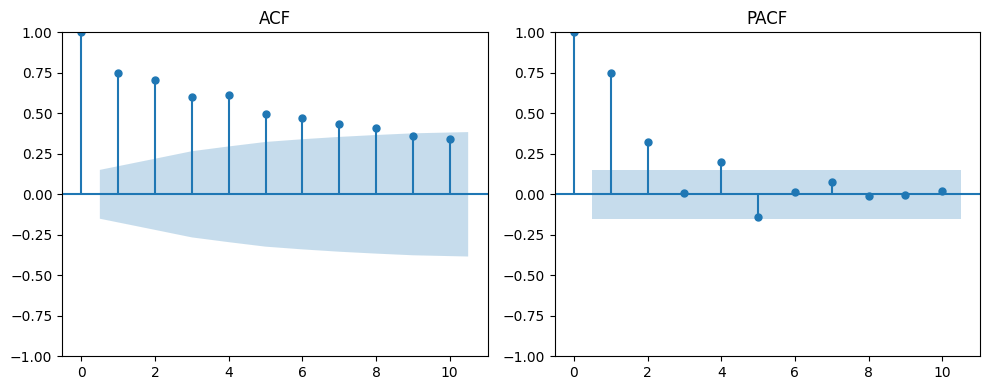

In [394]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# ACF
plot_acf(av_ny_y['y'], ax=ax[0], lags=10)
ax[0].set_title('ACF')

# PACF
plot_pacf(av_ny_y['y'], ax=ax[1], lags=10)
ax[1].set_title('PACF')


plt.tight_layout()
plt.show()

ACF is significant under 8 lags
PACF is significant under 2 lags

### Make time series stationary

In [395]:
av_ny_y['y_diff'] = av_ny_y['y'].diff()

Check on stationarity and autocorrelation

In [396]:
adf_test(av_ny_y['y_diff'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -6.78e+00
p-value                        2.56e-09
#Lags Used                     5.00e+00
Number of Observations Used    1.62e+02
Critical Value (1%)           -3.47e+00
Critical Value (5%)           -2.88e+00
Critical Value (10%)          -2.58e+00
dtype: float64


The defaults significance level is 5%.

<font color='green'>p-value < significance level </font>: :the **time series is stationary**.

In [397]:
best_params = []
for p in np.arange(0,7):
  for q in np.arange(0,7):
    model = ARIMA(av_ny_y['y_diff'], order=(p, 1, q)).fit();
    best_params.append({'p':p, 'q': q, 'AIC': model.aic, 'BIC': model.bic});

pd.DataFrame(best_params).sort_values(by="AIC").head()

,p,q,AIC,BIC
19,2,5,16.67,41.66
44,6,2,18.56,46.67
41,5,6,18.66,56.14
20,2,6,18.77,46.89
32,4,4,18.87,46.99


In [398]:
import statsmodels.api as sm
model = sm.tsa.SARIMAX(train.set_index('ds')['y'],
                    exog=regressors_train.set_index('ds')[['is_summer', 'Total Volume']],
                      order=(2, 1, 5),
                      seasonal_order=(1, 1, 1, 7), # season_length=52 for weekly data
                      enforce_stationarity=False,
                      enforce_invertibility=False)
results = model.fit()

In [399]:
forecast = results.get_forecast(steps=forecast_horizon, exog = regressors_test[['is_summer', 'Total Volume']])

In [400]:
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

forecast_df = pd.DataFrame({'y_hat': forecast_mean,
                           'lower_bound': forecast_ci.iloc[:, 0],
                           'upper_bound': forecast_ci.iloc[:, 1]},
                          index = test.set_index('ds').index)

In [401]:
fig = px.line(title="Avocado average price by week in NY")
fig.add_scatter(x=train.set_index('ds')['y'].index, y=train.set_index('ds')['y'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test.set_index('ds')['y'].index, y=test.set_index('ds')['y'], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=forecast_df['y_hat'].index, y=forecast_df['y_hat'], mode='lines', name='prediction', line=dict(color='red'))

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

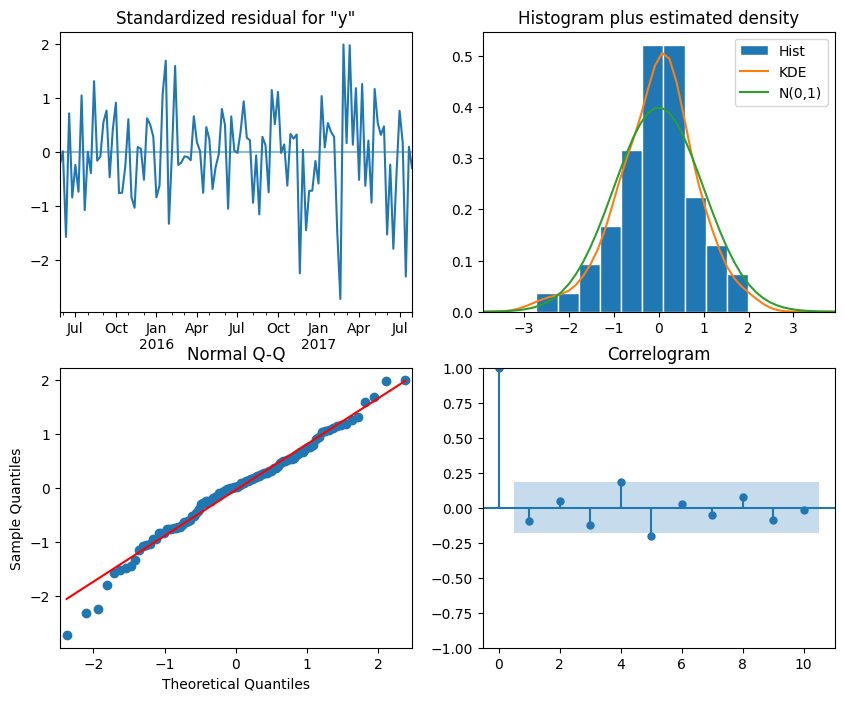

In [402]:
fig = results.plot_diagnostics(figsize=(10, 8))

- Top left: looks stationary and around 0
- Top right: high cupola tells about overfitting
- Bottom left: residuals at the edges tells about overfitting
- Bottom right: we don't have autocorrelation




In [403]:
residuals = forecast_df['y_hat'] - test.set_index('ds')['y']

In [404]:
residuals.mean()

-0.5843940995310608

The residual's mean is near 0. That's good

In [405]:
adf_test(residuals)

Results of Dickey-Fuller Test:
Test Statistic                 -3.14
p-value                         0.02
#Lags Used                      0.00
Number of Observations Used    33.00
Critical Value (1%)            -3.65
Critical Value (5%)            -2.95
Critical Value (10%)           -2.62
dtype: float64


The defaults significance level is 5%.

<font color='green'>p-value < significance level </font>: :  **residuals are stationary**.

In [406]:
acorr_ljungbox(residuals)

,lb_stat,lb_pvalue
1,8.42,3.71e-03
2,9.10,1.06e-02
3,9.13,2.77e-02
4,9.20,5.62e-02
5,9.97,7.62e-02
6,9.97,1.26e-01


The defaults significance level is 5%.

<font color='red'>p-value <= significance level</font>: Reject the null hypothesis H(0), **the time series is autocorrelated**.

That's bad

Let's measure error by using metrics

In [407]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

rmse = np.sqrt(mean_squared_error(test.set_index('ds')['y'], forecast_df['y_hat']))
print('RMSE: ', rmse)
mape = mean_absolute_percentage_error(test.set_index('ds')['y'], forecast_df['y_hat'])
print('MAPE: ', mape)

RMSE:  0.652786506493777
MAPE:  0.17711819714301003


## Prophet

We don't need unique_id

In [408]:
train_fp = train[['ds', 'y']]
test_fp = test[['ds', 'y']]

In [409]:
# 1. Create an object of the Prophet class
#(all model parameters are set in the class constructor, using default values)
m = fp.Prophet()

# 2. Train the model
m.fit(train_fp)

# 3. Create a table with dates covering both the historical data and the "forecast horizon"
future = m.make_future_dataframe(periods=forecast_horizon*7)

# 4. Obtain predictions for the dates generated in the previous step
forecast_prophet = m.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6w0ek7ww/sqh7o5bm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6w0ek7ww/ci3vbpn1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7648', 'data', 'file=/tmp/tmp6w0ek7ww/sqh7o5bm.json', 'init=/tmp/tmp6w0ek7ww/ci3vbpn1.json', 'output', 'file=/tmp/tmp6w0ek7ww/prophet_modelm32n_ewv/prophet_model-20241223121421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [410]:
fig = px.line(title="Avocado average price by week in NY")
fig.add_scatter(x=train['ds'], y=train['y'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test['ds'], y=test['y'], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=forecast_prophet['ds'], y=forecast_prophet['yhat'], mode='lines', name='forecast', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="sales")
fig.show()

In [411]:
forecast_prophet['unique_id'] = 'NY'

evaluation_prophet = evaluate(
    test.merge(forecast_prophet[['unique_id','ds','yhat']]),
    metrics=metrics,
    train_df=train
)
evaluation_prophet

,unique_id,metric,yhat
0,NY,rmse,0.55
1,NY,mape,0.15


Let's do cross-validation and compare

In [412]:
df_cv = cross_validation(m, initial='365.25 days', period='7 days', horizon = '7 days', parallel="processes")

INFO:prophet:Making 81 forecasts with cutoffs between 2016-01-10 00:00:00 and 2017-07-23 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7bb574c90dc0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6w0ek7ww/18ux5qti.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6w0ek7ww/m9a3a3f9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6w0ek7ww/hus00rl3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6w0ek7ww/o9d21pdp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90685', 'data', 'file=/tmp/tmp6w0ek7ww/18ux5qti.json', 'init=/tmp/tmp6w0ek7ww/hus00rl3.json', 'output', 'file=/tmp/tmp6w0ek7ww/prophet_modelau8neby_/prophet_model-20241223121422.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan arg

In [413]:
res = performance_metrics(df_cv, rolling_window = 1)
res

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,7 days,0.12,0.35,0.28,0.08,0.07,0.08,0.48


MAPE: 0.15 vs 0.08(CV)

In [414]:
print('SARIMAX:')
display(evaluation_sarimax)

print('Base Prophet:')
display(evaluation_prophet)

SARIMAX:


,unique_id,metric,y_hat
0,NewYork,rmse,0.31
1,NewYork,mape,0.07


Base Prophet:


,unique_id,metric,yhat
0,NY,rmse,0.55
1,NY,mape,0.15


## Prophet with regressors

In [415]:
train_fp_with_reg = regressors.join(train_fp.set_index('ds'), how='inner')[['is_summer','Total Volume','y']].reset_index()

In [416]:
# 1. Create an object of the Prophet class
# (all model parameters are set in the class constructor, using default values)
m_13 = fp.Prophet()

# 2. Add regressor
m_13.add_regressor('is_summer')
m_13.add_regressor('Total Volume')


# 3. Train the model
m_13.fit(train_fp_with_reg)

# 4. Create a table with dates covering both the historical data and the "forecast horizon"
future = m_13.make_future_dataframe(periods=forecast_horizon*7)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6w0ek7ww/znqnsk_u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6w0ek7ww/esjarxi6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46357', 'data', 'file=/tmp/tmp6w0ek7ww/znqnsk_u.json', 'init=/tmp/tmp6w0ek7ww/esjarxi6.json', 'output', 'file=/tmp/tmp6w0ek7ww/prophet_modelu1w7lrme/prophet_model-20241223121452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [417]:
forecast_13 = m_13.predict(future.set_index('ds').join(regressors[['is_summer', 'Total Volume']], how='inner').reset_index())

In [418]:
fig = px.line(title="Avocado average price by week in NY")
fig.add_scatter(x=train['ds'], y=train['y'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test['ds'], y=test['y'], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=forecast_prophet['ds'], y=forecast_prophet['yhat'], mode='lines', name='forecast', line=dict(color='red'))
fig.add_scatter(x=forecast_13['ds'], y=forecast_13['yhat'], mode='lines', name='forecast with regs', line=dict(color='violet'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="sales")
fig.show()

In [419]:
forecast_13['unique_id'] = 'NY'

evaluation_prophet_x = evaluate(
    test.merge(forecast_13[['unique_id','ds','yhat']]),
    metrics=metrics,
    train_df=train
)
evaluation_sarimax

,unique_id,metric,y_hat
0,NewYork,rmse,0.31
1,NewYork,mape,0.07


Let's do cross-validation and compare

In [420]:
df_cv = cross_validation(m_13, initial='365.25 days', period='7 days', horizon = '7 days', parallel="processes")

INFO:prophet:Making 81 forecasts with cutoffs between 2016-01-10 00:00:00 and 2017-07-23 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7bb55667a320>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6w0ek7ww/7twd81a6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6w0ek7ww/01vcuvno.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6w0ek7ww/hj0f0_kj.json
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6w0ek7ww/3h_re52o.json
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98026', 'data', 'file=/tmp/tmp6w0ek7ww/7twd81a6.json', 'init=/tmp/tmp6w0ek7ww/01vcuvno.json', 'output', 'file=/tmp/tmp6w0ek7ww/prophet_model303ywf03/prophet_model-20241223121453.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:14:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
D

In [421]:
res = performance_metrics(df_cv, rolling_window = 1)
res

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,7 days,0.09,0.3,0.24,0.07,0.06,0.07,0.49


MAPE: 0.15 vs 0.08(CV)

In [422]:
print('SARIMAX:')
display(evaluation_sarimax)

print('Base Prophet:')
display(evaluation_prophet)


print('Prophet with regressors:')
display(evaluation_prophet_x)

SARIMAX:


,unique_id,metric,y_hat
0,NewYork,rmse,0.31
1,NewYork,mape,0.07


Base Prophet:


,unique_id,metric,yhat
0,NY,rmse,0.55
1,NY,mape,0.15


Prophet with regressors:


,unique_id,metric,yhat
0,NY,rmse,0.38
1,NY,mape,0.10


## Tune prophet

In [423]:
param_grid = {
    'changepoint_prior_scale': [0.05,0.1,0.5],
    'seasonality_prior_scale': [0.001,0.1,10.0],
    'seasonality_mode':['multiplicative','additive'],
    'holidays_prior_scale':[1.0,5.0,10.0]
}

# Create all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

len(all_params)

54

['is_summer', 'Total Volume']

In [424]:
train_fp_with_reg

,ds,is_summer,Total Volume,y
0,2015-01-04,0,1.42e+06,3.02
1,2015-01-11,0,1.03e+06,3.37
2,2015-01-18,0,1.05e+06,3.45
3,2015-01-25,0,1.12e+06,3.38
4,2015-02-01,0,1.46e+06,3.29
5,2015-02-08,0,1.68e+06,3.06
6,2015-02-15,0,1.02e+06,3.27
7,2015-02-22,0,1.11e+06,3.54
8,2015-03-01,0,1.36e+06,3.18
9,2015-03-08,0,1.15e+06,3.26


In [425]:
mapes = []

# Cross validation
for params in tqdm(all_params):
    m = fp.Prophet(**params)  # Fit model with given params
    m.add_regressor('is_summer', mode=params['seasonality_mode'])
    m.add_regressor('Total Volume', mode=params['seasonality_mode'])
    m.fit(train_fp_with_reg)
    df_cv = cross_validation(m, initial='365.25 days', period='30 days', horizon = '30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mapes.append(df_p['mape'].values[0])

Выходные данные были обрезаны до нескольких последних строк (5000).
INFO:cmdstanpy:Chain [1] start processing
12:20:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6w0ek7ww/ixzlo081.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6w0ek7ww/vldkz9ug.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71978', 'data', 'file=/tmp/tmp6w0ek7ww/ixzlo081.json', 'init=/tmp/tmp6w0ek7ww/vldkz9ug.json', 'output', 'file=/tmp/tmp6w0ek7ww/prophet_model5eth6f1p/prophet_model-20241223122028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:20:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:20:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tm

In [426]:
res = performance_metrics(df_cv, rolling_window = 1)
res

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,0.15,0.38,0.3,0.08,0.06,0.08,0.44


In [427]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
tuning_results.sort_values(by='mape')
best_params = all_params[tuning_results.sort_values(by='mape').index[0]]
best_params

{'changepoint_prior_scale': 0.1,
 'seasonality_prior_scale': 10.0,
 'seasonality_mode': 'additive',
 'holidays_prior_scale': 10.0}

## Best prophet

In [428]:
# 1. Create an object of the Prophet class
# (all model parameters are set in the class constructor, using default values)
m_13 = fp.Prophet(**best_params)

# 2. Add regressor
m_13.add_regressor('is_summer')
m_13.add_regressor('Total Volume')


# 3. Train the model
m_13.fit(train_fp_with_reg)

# 4. Create a table with dates covering both the historical data and the "forecast horizon"
future = m_13.make_future_dataframe(periods=forecast_horizon*7)


forecast_tuned = m_13.predict(future.set_index('ds').join(regressors[['is_summer', 'Total Volume']], how='inner').reset_index())

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6w0ek7ww/ny8eif3f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6w0ek7ww/pt4qstl2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67528', 'data', 'file=/tmp/tmp6w0ek7ww/ny8eif3f.json', 'init=/tmp/tmp6w0ek7ww/pt4qstl2.json', 'output', 'file=/tmp/tmp6w0ek7ww/prophet_modelrfd_ncjo/prophet_model-20241223122615.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:26:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:26:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [429]:
fig = px.line(title="Avocado average price by week in NY")
fig.add_scatter(x=train['ds'], y=train['y'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test['ds'], y=test['y'], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=forecast_prophet['ds'], y=forecast_prophet['yhat'], mode='lines', name='forecast', line=dict(color='red'))
fig.add_scatter(x=forecast_13['ds'], y=forecast_13['yhat'], mode='lines', name='forecast with regs', line=dict(color='violet'))
fig.add_scatter(x=forecast_tuned['ds'], y=forecast_tuned['yhat'], mode='lines', name='tuned forecast with regs', line=dict(color='orange'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="sales")
fig.show()

In [430]:
forecast_tuned['unique_id'] = 'sales'

evaluation_prophet_tuned = evaluate(
    test.merge(forecast_tuned[['unique_id','ds','yhat']]),
    metrics=metrics,
    train_df=train
)
evaluation_prophet_tuned

,unique_id,metric,yhat
0,sales,rmse,0.27
1,sales,mape,0.07


In [431]:
print('SARIMAX:')
display(evaluation_sarimax)

print('Base Prophet:')
display(evaluation_prophet)


print('Prophet with regressors:')
display(evaluation_prophet_x)

print('Tuned prophet with regressors:')
display(evaluation_prophet_tuned)

SARIMAX:


,unique_id,metric,y_hat
0,NewYork,rmse,0.31
1,NewYork,mape,0.07


Base Prophet:


,unique_id,metric,yhat
0,NY,rmse,0.55
1,NY,mape,0.15


Prophet with regressors:


,unique_id,metric,yhat
0,NY,rmse,0.38
1,NY,mape,0.10


Tuned prophet with regressors:


,unique_id,metric,yhat
0,sales,rmse,0.27
1,sales,mape,0.07


## MSTL

In [432]:
models = [
    MSTL(
        season_length=[7, 31, 365], # define seasonal periods
        trend_forecaster=AutoARIMA()
        # (method='CSS-ML') # there can be different models, but let's use AutoARIMA for now
        )
]

sf = StatsForecast(models=models, freq='W', n_jobs=-1)

forecast = sf.forecast(df=train, h=forecast_horizon)


fig = px.line(title="Avocado average price by week in NY")
fig.add_scatter(x=train['ds'], y=train['y'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test['ds'], y=test['y'], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=forecast['ds'], y=forecast['MSTL'], mode='lines', name='forecast', line=dict(color='red'))

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="sales")
fig.show()

In [433]:
evaluation_MSTL = evaluate(
    test.merge(forecast),
    metrics=metrics,
    train_df=train
)

In [434]:
print('SARIMAX:')
display(evaluation_sarimax)

print('Base Prophet:')
display(evaluation_prophet)


print('Prophet with regressors:')
display(evaluation_prophet_x)

print('Tuned prophet with regressors:')
display(evaluation_prophet_tuned)

print('MSTL:')
display(evaluation_MSTL)

SARIMAX:


,unique_id,metric,y_hat
0,NewYork,rmse,0.31
1,NewYork,mape,0.07


Base Prophet:


,unique_id,metric,yhat
0,NY,rmse,0.55
1,NY,mape,0.15


Prophet with regressors:


,unique_id,metric,yhat
0,NY,rmse,0.38
1,NY,mape,0.10


Tuned prophet with regressors:


,unique_id,metric,yhat
0,sales,rmse,0.27
1,sales,mape,0.07


MSTL:


,unique_id,metric,MSTL
0,NewYork,rmse,0.43
1,NewYork,mape,0.11


## Seasonal naive

In [435]:
models = [SeasonalNaive(season_length=7)]
sf = StatsForecast(models=models, freq='W', n_jobs=-1)

forecast = sf.forecast(df=train, h=forecast_horizon)
forecast

,unique_id,ds,SeasonalNaive
0,NewYork,2017-08-06,3.73
1,NewYork,2017-08-13,3.83
2,NewYork,2017-08-20,4.16
3,NewYork,2017-08-27,4.11
4,NewYork,2017-09-03,3.36
5,NewYork,2017-09-10,3.40
6,NewYork,2017-09-17,3.40
7,NewYork,2017-09-24,3.73
8,NewYork,2017-10-01,3.83
9,NewYork,2017-10-08,4.16


In [436]:
fig = px.line(title="Avocado average price by week in NY")
fig.add_scatter(x=train['ds'], y=train['y'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test['ds'], y=test['y'], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=forecast['ds'], y=forecast['SeasonalNaive'], mode='lines', name='forecast', line=dict(color='red'))

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="sales")
fig.show()

In [437]:
evaluation_seasonal_naive = evaluate(
    test.merge(forecast),
    metrics=metrics,
    train_df=train
)
evaluation_seasonal_naive

,unique_id,metric,SeasonalNaive
0,NewYork,rmse,0.52
1,NewYork,mape,0.13


In [438]:
print('SARIMAX:')
display(evaluation_sarimax)

print('Base Prophet:')
display(evaluation_prophet)


print('Prophet with regressors:')
display(evaluation_prophet_x)

print('Tuned prophet with regressors:')
display(evaluation_prophet_tuned)

print('MSTL:')
display(evaluation_MSTL)

print('Seasonal naive:')
display(evaluation_seasonal_naive)


SARIMAX:


,unique_id,metric,y_hat
0,NewYork,rmse,0.31
1,NewYork,mape,0.07


Base Prophet:


,unique_id,metric,yhat
0,NY,rmse,0.55
1,NY,mape,0.15


Prophet with regressors:


,unique_id,metric,yhat
0,NY,rmse,0.38
1,NY,mape,0.10


Tuned prophet with regressors:


,unique_id,metric,yhat
0,sales,rmse,0.27
1,sales,mape,0.07


MSTL:


,unique_id,metric,MSTL
0,NewYork,rmse,0.43
1,NewYork,mape,0.11


Seasonal naive:


,unique_id,metric,SeasonalNaive
0,NewYork,rmse,0.52
1,NewYork,mape,0.13


As we can see from metrics the best model is Tuned prophet with regressors

## Out-of-sample forecast on the best model

We train on all dataset of time series and will be make a prediction on the future 14 weeks

In [439]:
regressors_2 = av_ny_y.join(regressors[['is_summer', 'Total Volume', 'unique_id']], how='inner')
regressors_2 = regressors_2.reset_index()[['ds', 'is_summer', 'Total Volume','y']]

In [440]:
date_range = pd.date_range(start=av_ny_y.index.max(), end='2018-06-25 00:00:00', freq='W')
regressors_f = pd.DataFrame(date_range, columns=["ds"])
regressors_f["is_summer"] = regressors_f["ds"].dt.month.isin([6, 7, 8]).astype(int)
regressors_f['unique_id'] = 'NewYork'
regressors_f['Total Volume'] = np.random.normal(loc=regressors_2['Total Volume'].mean(), size=14)

In [441]:
# 1. Create an object of the Prophet class
# (all model parameters are set in the class constructor, using default values)
m_13 = fp.Prophet(**best_params)

# 2. Add regressor
m_13.add_regressor('is_summer')
m_13.add_regressor('Total Volume')


# 3. Train the model
m_13.fit(regressors_2)

best_forecast_tuned = m_13.predict(regressors_f)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6w0ek7ww/weshnjup.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6w0ek7ww/wqybqpae.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93360', 'data', 'file=/tmp/tmp6w0ek7ww/weshnjup.json', 'init=/tmp/tmp6w0ek7ww/wqybqpae.json', 'output', 'file=/tmp/tmp6w0ek7ww/prophet_modeltefzdjj1/prophet_model-20241223122617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:26:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:26:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [442]:
fig = px.line(title="Avocado average price by week in NY in the future")
fig.add_scatter(x=regressors_2['ds'], y=regressors_2['y'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=best_forecast_tuned['ds'], y=best_forecast_tuned['yhat'], mode='lines', name='forecast', line=dict(color='red'))

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="sales")
fig.show()

# SanFrancisco

## Prepare DATA

In [490]:
av_sf = av_data[av_data['region'] == 'SanFrancisco']

In [491]:
av_sf.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
2184,0,2015-12-27,1.05,692206.40,181704.67,422617.80,28184.73,59699.20,59094.49,582.90,21.81,conventional,2015,SanFrancisco
2185,1,2015-12-20,1.15,637091.48,173521.67,364622.31,33083.99,65863.51,65038.10,766.09,59.32,conventional,2015,SanFrancisco
2186,2,2015-12-13,1.22,616016.46,127080.03,384958.63,34069.96,69907.84,69022.62,781.91,103.31,conventional,2015,SanFrancisco
2187,3,2015-12-06,1.06,694982.49,102771.75,498975.34,37321.12,55914.28,55171.77,638.89,103.62,conventional,2015,SanFrancisco
2188,4,2015-11-29,1.05,651638.60,102783.08,462966.47,31195.04,54694.01,53992.69,647.78,53.54,conventional,2015,SanFrancisco


In [492]:
av_sf.rename(columns={'Date':'ds', 'AveragePrice':'y'}, inplace=True)

In [493]:
av_sf = av_sf[['ds','y','Total Volume']].sort_values(by='ds').set_index('ds')

Group our data by week

In [494]:
av_sf = av_sf.resample('W').sum()

We will take column "Total Volume" as a continuous regressor in this work

In [495]:
av_sf_x = av_sf.copy(deep=True)

In [497]:
av_sf_y = av_sf['y'].to_frame()

In [498]:
av_sf_y

,y
ds,
2015-01-04,2.17
2015-01-11,2.15
2015-01-18,2.49
2015-01-25,2.55
2015-02-01,1.97
2015-02-08,2.27
2015-02-15,2.78
2015-02-22,2.62
2015-03-01,2.04


Now let's plot the data.

In [499]:
fig = px.line(av_sf_y, x=av_sf_y.index, y=av_sf_y['y'],
              title="Avocado average price by week in SanFrancisco")

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="sales")
fig.show()

Split time series into train/test in proportion 80/20

In [500]:
train_size = int(len(av_sf_y) * 0.80)
train, test = av_sf_y[:train_size], av_sf_y[train_size:]

train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [501]:
fig = px.line(title="Avocado average price by week in SanFrancisco")
fig.add_scatter(x=train['ds'], y=train['y'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test['ds'], y=test['y'], mode='lines', name='test', line=dict(color='green'))

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

## Choosing regressors (same as NY)

Dummy: summer - 1, another - 0. As summer is the season for growing Avocados in the country

Continuous: total_value.

In [505]:
date_range = pd.date_range(start=av_sf_y.index.min(), end=av_sf_y.index.max())

# Create the DataFrame
regressors = pd.DataFrame(date_range, columns=["ds"])

In [506]:
regressors["is_summer"] = regressors["ds"].dt.month.isin([6, 7, 8]).astype(int)

regressors.set_index('ds', inplace=True)

regressors = regressors.join(av_sf_y)[['is_summer']]

In [507]:
regressors = regressors.join(av_sf_x['Total Volume'], how='inner').loc[regressors.index.min():regressors.index.max()][['is_summer', 'Total Volume']]

In [508]:
regressors['unique_id'] = 'SanFrancisco' # add unique_id for Nixtla
regressors

,is_summer,Total Volume,unique_id
ds,,,
2015-01-04,0,9.30e+05,SanFrancisco
2015-01-11,0,9.46e+05,SanFrancisco
2015-01-18,0,7.95e+05,SanFrancisco
2015-01-25,0,7.41e+05,SanFrancisco
2015-02-01,0,1.41e+06,SanFrancisco
2015-02-08,0,9.56e+05,SanFrancisco
2015-02-15,0,7.22e+05,SanFrancisco
2015-02-22,0,8.14e+05,SanFrancisco
2015-03-01,0,1.09e+06,SanFrancisco


Let's also see how Total Volume are connected to the time series.

In [509]:
import plotly.graph_objects as go

# Create an empty fig
fig = go.Figure()

# Add y graph on the left
fig.add_trace(go.Scatter(
    x=av_sf_y.index,
    y=av_sf_y['y'],
    mode='lines',
    name='y',
    line=dict(color='blue'),
    yaxis='y1'  # Tie to y1
))

# Add x graph on the right
fig.add_trace(go.Scatter(
    x=regressors.index,
    y=regressors['Total Volume'],
    mode='lines',
    name='Total Volume',
    line=dict(color='red'),
    yaxis='y2'  # Tie to y1
))


fig.update_layout(
    title="Averge price of avocado in SF",
    template='plotly_white',
    width=1000,
    height=500,
    yaxis=dict(
        title='y',
    ),
    yaxis2=dict(
        title='Total Volume',
        overlaying='y',  # Impose axes
        side='right'
    ),
    xaxis=dict(title='Date')
)

# Отображаем график
fig.show()

It seems, that Total Volume correlate with the average price in some time. I think it can help our prediction

Split regressors on train, test.

In [510]:
regressors_train, regressors_test = regressors[:train_size], regressors[train_size:]
regressors_train = regressors_train.reset_index()
regressors_test = regressors_test.reset_index()

## SARIMAX

Let's train the model.

In [511]:
forecast_horizon = len(av_sf_y) - train_size
forecast_horizon

34

In [512]:
train['unique_id'] = 'SanFrancisco'
train

,ds,y,unique_id
0,2015-01-04,2.17,SanFrancisco
1,2015-01-11,2.15,SanFrancisco
2,2015-01-18,2.49,SanFrancisco
3,2015-01-25,2.55,SanFrancisco
4,2015-02-01,1.97,SanFrancisco
5,2015-02-08,2.27,SanFrancisco
6,2015-02-15,2.78,SanFrancisco
7,2015-02-22,2.62,SanFrancisco
8,2015-03-01,2.04,SanFrancisco
9,2015-03-08,2.72,SanFrancisco


In [513]:
# Initialize the model
models = [AutoARIMA(seasonal=True, season_length=7, approximation=True)]
sf_with_reg = StatsForecast(models=models, freq='W', n_jobs=-1)

# forecast method combines fit and predict and works faster due to optimization
forecast_with_reg = sf_with_reg.forecast(df=train.merge(regressors_train, how='left', on=['unique_id', 'ds']),
                                         X_df=regressors_test, h=forecast_horizon)


In [514]:
forecast_with_reg.columns = ['unique_id', 'ds', 'y_hat']
forecast_with_reg

,unique_id,ds,y_hat
0,SanFrancisco,2017-08-06,3.70
1,SanFrancisco,2017-08-13,3.54
2,SanFrancisco,2017-08-20,3.93
3,SanFrancisco,2017-08-27,3.88
4,SanFrancisco,2017-09-03,3.71
5,SanFrancisco,2017-09-10,3.67
6,SanFrancisco,2017-09-17,3.72
7,SanFrancisco,2017-09-24,3.73
8,SanFrancisco,2017-10-01,3.72
9,SanFrancisco,2017-10-08,3.54


In [515]:
fig = px.line(title="Average price of avocado in SF")
fig.add_scatter(x=train['ds'], y=train['y'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test['ds'], y=test['y'], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=forecast_with_reg['ds'], y=forecast_with_reg['y_hat'], mode='lines', name='forecast_with_reg', line=dict(color='orange'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="Average price")
fig.show()

Measure the quality of prediciton

In [520]:
metrics = [rmse, mape]
evaluation_sarimax = evaluate(
    test.merge(forecast_with_reg),
    metrics=metrics,
    train_df=train
)
evaluation_sarimax

,unique_id,metric,y_hat
0,SanFrancisco,rmse,0.35
1,SanFrancisco,mape,0.07


## Prophet

We don't need unique_id

In [521]:
train_fp = train[['ds', 'y']]
test_fp = test[['ds', 'y']]

In [522]:
# 1. Create an object of the Prophet class
#(all model parameters are set in the class constructor, using default values)
m = fp.Prophet()

# 2. Train the model
m.fit(train_fp)

# 3. Create a table with dates covering both the historical data and the "forecast horizon"
future = m.make_future_dataframe(periods=forecast_horizon*7)

# 4. Obtain predictions for the dates generated in the previous step
forecast_prophet = m.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6w0ek7ww/xgk0zcqd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6w0ek7ww/2w3mty8b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91834', 'data', 'file=/tmp/tmp6w0ek7ww/xgk0zcqd.json', 'init=/tmp/tmp6w0ek7ww/2w3mty8b.json', 'output', 'file=/tmp/tmp6w0ek7ww/prophet_modelcpj62vnt/prophet_model-20241223123121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:31:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:31:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [523]:
fig = px.line(title="Average price of avocado in SF")
fig.add_scatter(x=train['ds'], y=train['y'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test['ds'], y=test['y'], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=forecast_prophet['ds'], y=forecast_prophet['yhat'], mode='lines', name='forecast', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="sales")
fig.show()

In [524]:
forecast_prophet['unique_id'] = 'SF'

evaluation_prophet = evaluate(
    test.merge(forecast_prophet[['unique_id','ds','yhat']]),
    metrics=metrics,
    train_df=train
)
evaluation_prophet

,unique_id,metric,yhat
0,SF,rmse,1.26
1,SF,mape,0.37


In [525]:
print('SARIMAX:')
display(evaluation_sarimax)

print('Base Prophet:')
display(evaluation_prophet)

SARIMAX:


,unique_id,metric,y_hat
0,SanFrancisco,rmse,0.35
1,SanFrancisco,mape,0.07


Base Prophet:


,unique_id,metric,yhat
0,SF,rmse,1.26
1,SF,mape,0.37


## Prophet with regressors

In [526]:
train_fp_with_reg = regressors.join(train_fp.set_index('ds'), how='inner')[['is_summer','Total Volume','y']].reset_index()
train_fp_with_reg

,ds,is_summer,Total Volume,y
0,2015-01-04,0,9.30e+05,2.17
1,2015-01-11,0,9.46e+05,2.15
2,2015-01-18,0,7.95e+05,2.49
3,2015-01-25,0,7.41e+05,2.55
4,2015-02-01,0,1.41e+06,1.97
5,2015-02-08,0,9.56e+05,2.27
6,2015-02-15,0,7.22e+05,2.78
7,2015-02-22,0,8.14e+05,2.62
8,2015-03-01,0,1.09e+06,2.04
9,2015-03-08,0,8.51e+05,2.72


In [527]:
# 1. Create an object of the Prophet class
# (all model parameters are set in the class constructor, using default values)
m_13 = fp.Prophet()

# 2. Add regressor
m_13.add_regressor('is_summer')
m_13.add_regressor('Total Volume')


# 3. Train the model
m_13.fit(train_fp_with_reg)

# 4. Create a table with dates covering both the historical data and the "forecast horizon"
future = m_13.make_future_dataframe(periods=forecast_horizon*7)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6w0ek7ww/9vka9xt6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6w0ek7ww/mnt650fc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15626', 'data', 'file=/tmp/tmp6w0ek7ww/9vka9xt6.json', 'init=/tmp/tmp6w0ek7ww/mnt650fc.json', 'output', 'file=/tmp/tmp6w0ek7ww/prophet_model8f6s54q8/prophet_model-20241223123122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:31:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:31:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [528]:
forecast_13 = m_13.predict(future.set_index('ds').join(regressors[['is_summer', 'Total Volume']], how='inner').reset_index())

In [529]:
fig = px.line(title="Average price of avocado in SF")
fig.add_scatter(x=train['ds'], y=train['y'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test['ds'], y=test['y'], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=forecast_prophet['ds'], y=forecast_prophet['yhat'], mode='lines', name='forecast', line=dict(color='red'))
fig.add_scatter(x=forecast_13['ds'], y=forecast_13['yhat'], mode='lines', name='forecast with regs', line=dict(color='violet'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="sales")
fig.show()

In [530]:
forecast_13['unique_id'] = 'SF'

evaluation_prophet_x = evaluate(
    test.merge(forecast_13[['unique_id','ds','yhat']]),
    metrics=metrics,
    train_df=train
)
evaluation_prophet_x

,unique_id,metric,yhat
0,SF,rmse,0.86
1,SF,mape,0.23


In [531]:
print('SARIMAX:')
display(evaluation_sarimax)

print('Base Prophet:')
display(evaluation_prophet)


print('Prophet with regressors:')
display(evaluation_prophet_x)

SARIMAX:


,unique_id,metric,y_hat
0,SanFrancisco,rmse,0.35
1,SanFrancisco,mape,0.07


Base Prophet:


,unique_id,metric,yhat
0,SF,rmse,1.26
1,SF,mape,0.37


Prophet with regressors:


,unique_id,metric,yhat
0,SF,rmse,0.86
1,SF,mape,0.23


## Tune prophet

In [532]:
param_grid = {
    'changepoint_prior_scale': [0.05,0.1,0.5],
    'seasonality_prior_scale': [0.001,0.1,10.0],
    'seasonality_mode':['multiplicative','additive'],
    'holidays_prior_scale':[1.0,5.0,10.0]
}

# Create all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

len(all_params)

54

In [533]:
mapes = []

# Cross validation
for params in tqdm(all_params):
    m = fp.Prophet(**params)  # Fit model with given params
    m.add_regressor('is_summer', mode=params['seasonality_mode'])
    m.add_regressor('Total Volume', mode=params['seasonality_mode'])
    m.fit(train_fp_with_reg)
    df_cv = cross_validation(m, initial='365.25 days', period='30 days', horizon = '30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mapes.append(df_p['mape'].values[0])

Выходные данные были обрезаны до нескольких последних строк (5000).
INFO:cmdstanpy:Chain [1] start processing
12:35:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6w0ek7ww/b0fonlgq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6w0ek7ww/6if5go4z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43394', 'data', 'file=/tmp/tmp6w0ek7ww/b0fonlgq.json', 'init=/tmp/tmp6w0ek7ww/6if5go4z.json', 'output', 'file=/tmp/tmp6w0ek7ww/prophet_modellgzt7878/prophet_model-20241223123530.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:35:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:35:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tm

In [534]:
res = performance_metrics(df_cv, rolling_window = 1)
res

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,0.27,0.52,0.39,0.1,0.07,0.1,0.32


In [535]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
tuning_results.sort_values(by='mape')
best_params = all_params[tuning_results.sort_values(by='mape').index[0]]
best_params

{'changepoint_prior_scale': 0.05,
 'seasonality_prior_scale': 0.001,
 'seasonality_mode': 'additive',
 'holidays_prior_scale': 5.0}

## Best prophet

In [536]:
# 1. Create an object of the Prophet class
# (all model parameters are set in the class constructor, using default values)
m_13 = fp.Prophet(**best_params)

# 2. Add regressor
m_13.add_regressor('is_summer')
m_13.add_regressor('Total Volume')


# 3. Train the model
m_13.fit(train_fp_with_reg)

# 4. Create a table with dates covering both the historical data and the "forecast horizon"
future = m_13.make_future_dataframe(periods=forecast_horizon*7)


forecast_tuned = m_13.predict(future.set_index('ds').join(regressors[['is_summer', 'Total Volume']], how='inner').reset_index())

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6w0ek7ww/16e9jn2k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6w0ek7ww/2p0t3vfc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80595', 'data', 'file=/tmp/tmp6w0ek7ww/16e9jn2k.json', 'init=/tmp/tmp6w0ek7ww/2p0t3vfc.json', 'output', 'file=/tmp/tmp6w0ek7ww/prophet_modelrpt71foz/prophet_model-20241223124116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:41:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:41:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [537]:
fig = px.line(title="Average price of avocado in SF")
fig.add_scatter(x=train['ds'], y=train['y'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test['ds'], y=test['y'], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=forecast_prophet['ds'], y=forecast_prophet['yhat'], mode='lines', name='forecast', line=dict(color='red'))
fig.add_scatter(x=forecast_13['ds'], y=forecast_13['yhat'], mode='lines', name='forecast with regs', line=dict(color='violet'))
fig.add_scatter(x=forecast_tuned['ds'], y=forecast_tuned['yhat'], mode='lines', name='tuned forecast with regs', line=dict(color='orange'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="sales")
fig.show()

In [538]:
forecast_tuned['unique_id'] = 'SF'

evaluation_prophet_tuned = evaluate(
    test.merge(forecast_tuned[['unique_id','ds','yhat']]),
    metrics=metrics,
    train_df=train
)
evaluation_prophet_tuned

,unique_id,metric,yhat
0,SF,rmse,0.74
1,SF,mape,0.21


In [539]:
print('SARIMAX:')
display(evaluation_sarimax)

print('Base Prophet:')
display(evaluation_prophet)


print('Prophet with regressors:')
display(evaluation_prophet_x)

print('Tuned prophet with regressors:')
display(evaluation_prophet_tuned)

SARIMAX:


,unique_id,metric,y_hat
0,SanFrancisco,rmse,0.35
1,SanFrancisco,mape,0.07


Base Prophet:


,unique_id,metric,yhat
0,SF,rmse,1.26
1,SF,mape,0.37


Prophet with regressors:


,unique_id,metric,yhat
0,SF,rmse,0.86
1,SF,mape,0.23


Tuned prophet with regressors:


,unique_id,metric,yhat
0,SF,rmse,0.74
1,SF,mape,0.21


## MSTL

In [540]:
models = [
    MSTL(
        season_length=[51, 365], # define seasonal periods
        trend_forecaster=AutoARIMA()
        # (method='CSS-ML') # there can be different models, but let's use AutoARIMA for now
        )
]

sf = StatsForecast(models=models, freq='W', n_jobs=-1)

forecast = sf.forecast(df=train, h=forecast_horizon)


fig = px.line(title="Average price on avocado")
fig.add_scatter(x=train['ds'], y=train['y'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test['ds'], y=test['y'], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=forecast['ds'], y=forecast['MSTL'], mode='lines', name='forecast', line=dict(color='red'))

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="sales")
fig.show()

In [541]:
evaluation_MSTL = evaluate(
    test.merge(forecast),
    metrics=metrics,
    train_df=train
)
evaluation_MSTL

,unique_id,metric,MSTL
0,SanFrancisco,rmse,0.81
1,SanFrancisco,mape,0.20


In [542]:
print('SARIMAX:')
display(evaluation_sarimax)

print('Base Prophet:')
display(evaluation_prophet)


print('Prophet with regressors:')
display(evaluation_prophet_x)

print('Tuned prophet with regressors:')
display(evaluation_prophet_tuned)

print('MSTL:')
display(evaluation_MSTL)

SARIMAX:


,unique_id,metric,y_hat
0,SanFrancisco,rmse,0.35
1,SanFrancisco,mape,0.07


Base Prophet:


,unique_id,metric,yhat
0,SF,rmse,1.26
1,SF,mape,0.37


Prophet with regressors:


,unique_id,metric,yhat
0,SF,rmse,0.86
1,SF,mape,0.23


Tuned prophet with regressors:


,unique_id,metric,yhat
0,SF,rmse,0.74
1,SF,mape,0.21


MSTL:


,unique_id,metric,MSTL
0,SanFrancisco,rmse,0.81
1,SanFrancisco,mape,0.20


## Seasonal naive

In [543]:
models = [SeasonalNaive(season_length=7)]
sf = StatsForecast(models=models, freq='W', n_jobs=-1)

forecast = sf.forecast(df=train, h=forecast_horizon)
forecast

,unique_id,ds,SeasonalNaive
0,SanFrancisco,2017-08-06,4.53
1,SanFrancisco,2017-08-13,4.19
2,SanFrancisco,2017-08-20,4.29
3,SanFrancisco,2017-08-27,4.14
4,SanFrancisco,2017-09-03,4.14
5,SanFrancisco,2017-09-10,4.10
6,SanFrancisco,2017-09-17,3.44
7,SanFrancisco,2017-09-24,4.53
8,SanFrancisco,2017-10-01,4.19
9,SanFrancisco,2017-10-08,4.29


In [544]:
fig = px.line(title="Average price of avocado in SF")
fig.add_scatter(x=train['ds'], y=train['y'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test['ds'], y=test['y'], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=forecast['ds'], y=forecast['SeasonalNaive'], mode='lines', name='forecast', line=dict(color='red'))

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="sales")
fig.show()

In [545]:
evaluation_seasonal_naive = evaluate(
    test.merge(forecast),
    metrics=metrics,
    train_df=train
)
evaluation_seasonal_naive

,unique_id,metric,SeasonalNaive
0,SanFrancisco,rmse,0.93
1,SanFrancisco,mape,0.25


In [546]:
print('SARIMAX:')
display(evaluation_sarimax)

print('Base Prophet:')
display(evaluation_prophet)


print('Prophet with regressors:')
display(evaluation_prophet_x)

print('Tuned prophet with regressors:')
display(evaluation_prophet_tuned)

print('MSTL:')
display(evaluation_MSTL)

print('Seasonal naive:')
display(evaluation_seasonal_naive)


SARIMAX:


,unique_id,metric,y_hat
0,SanFrancisco,rmse,0.35
1,SanFrancisco,mape,0.07


Base Prophet:


,unique_id,metric,yhat
0,SF,rmse,1.26
1,SF,mape,0.37


Prophet with regressors:


,unique_id,metric,yhat
0,SF,rmse,0.86
1,SF,mape,0.23


Tuned prophet with regressors:


,unique_id,metric,yhat
0,SF,rmse,0.74
1,SF,mape,0.21


MSTL:


,unique_id,metric,MSTL
0,SanFrancisco,rmse,0.81
1,SanFrancisco,mape,0.20


Seasonal naive:


,unique_id,metric,SeasonalNaive
0,SanFrancisco,rmse,0.93
1,SanFrancisco,mape,0.25


As we can see from metrics the best model is SARIMAX

## Out-of-sample forecast on the best model

We train on all dataset of time series and will be make a prediction on the future 14 weeks

In [547]:
regressors_2 = av_sf_y.join(regressors[['is_summer', 'Total Volume', 'unique_id']], how='inner')
regressors_2 = regressors_2.reset_index()[['ds', 'is_summer', 'Total Volume','y']]

In [548]:
date_range = pd.date_range(start=av_sf_y.index.max(), end='2018-06-25 00:00:00', freq='W')
regressors_f = pd.DataFrame(date_range, columns=["ds"])
regressors_f["is_summer"] = regressors_f["ds"].dt.month.isin([6, 7, 8]).astype(int)
regressors_f['unique_id'] = 'NewYork'
regressors_f['Total Volume'] = np.random.normal(loc=regressors_2['Total Volume'].mean(), size=14)

In [549]:
# 1. Create an object of the Prophet class
# (all model parameters are set in the class constructor, using default values)
m_13 = fp.Prophet(**best_params)

# 2. Add regressor
m_13.add_regressor('is_summer')
m_13.add_regressor('Total Volume')


# 3. Train the model
m_13.fit(regressors_2)

best_forecast_tuned = m_13.predict(regressors_f)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6w0ek7ww/7fvmb0lu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6w0ek7ww/krnbjt5e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30886', 'data', 'file=/tmp/tmp6w0ek7ww/7fvmb0lu.json', 'init=/tmp/tmp6w0ek7ww/krnbjt5e.json', 'output', 'file=/tmp/tmp6w0ek7ww/prophet_modelkznrvsv0/prophet_model-20241223124117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:41:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:41:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [550]:
fig = px.line(title="Average price of avocado in SF")
fig.add_scatter(x=regressors_2['ds'], y=regressors_2['y'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=best_forecast_tuned['ds'], y=best_forecast_tuned['yhat'], mode='lines', name='forecast', line=dict(color='red'))

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="sales")
fig.show()